<a href="https://colab.research.google.com/github/tinghe14/-Coursera-/blob/main/gene_list_dgbib_civic_oncokb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib import pyplot as plt 
%matplotlib inline

## Dgidb Interaction File
- named: interactions.tsv on 2022-Feb

In [70]:
dgidb_int = pd.read_csv('dgidb_interactions.tsv', sep='\t')
dgidb_int.head(5)

,gene_name,gene_claim_name,entrez_id,interaction_claim_source,interaction_types,drug_claim_name,drug_claim_primary_name,drug_name,drug_concept_id,interaction_group_score,PMIDs
0,CDK7,CDK7,1022.0,CancerCommons,inhibitor,SNS-032,SNS-032,BMS-387032,chembl:CHEMBL296468,0.82,NaN
1,VDR,VDR,7421.0,DTC,NaN,NIFEKALANT,NIFEKALANT,NIFEKALANT,chembl:CHEMBL360861,0.14,NaN
2,GPR55,GPR55,9290.0,DTC,NaN,BISACODYL,BISACODYL,BISACODYL,chembl:CHEMBL942,0.94,NaN
3,NR1H4,NR1H4,9971.0,DTC,NaN,PENTACHLOROPHENOL,PENTACHLOROPHENOL,PENTACHLOROPHENOL,chembl:CHEMBL75967,0.07,NaN
4,FGFR2,FGFR2,2263.0,JAX-CKB,NaN,AZ6089,AZ6089,NaN,NaN,NaN,22869148


In [71]:
# distribution of interaction relationship sources without any precleaning
# oncokb is not the major sources, major: DTC, GuideToPharmacology, TTD
dgidb_int.groupby('interaction_claim_source').count()['gene_name']

interaction_claim_source
CIViC                                959
COSMIC                                37
CancerCommons                        109
ChemblInteractions                  7608
ClearityFoundationBiomarkers         163
ClearityFoundationClinicalTrial      239
DTC                                23877
DoCM                                  76
FDA                                  405
GuideToPharmacology                14081
JAX-CKB                             1962
MyCancerGenome                       863
MyCancerGenomeClinicalTrial          311
NCI                                 6196
OncoKB                               148
PharmGKB                            5078
TALC                                 547
TEND                                2242
TTD                                12375
TdgClinicalTrial                    5060
Name: gene_name, dtype: int64

In [72]:
# select features for further mapping
dgidb_i = dgidb_int[['gene_name','drug_name','interaction_claim_source']]
dgidb_i

,gene_name,drug_name,interaction_claim_source
0,CDK7,BMS-387032,CancerCommons
1,VDR,NIFEKALANT,DTC
2,GPR55,BISACODYL,DTC
3,NR1H4,PENTACHLOROPHENOL,DTC
4,FGFR2,NaN,JAX-CKB
...,...,...,...
85455,PIK3C3,INFIGRATINIB,MyCancerGenome
85456,ABL1,NaN,TTD
85457,CACNA1D,NaN,GuideToPharmacology
85458,PRKCA,RESVERATROL,DTC


In [73]:
# change the drug name into lower case in order for mapping
dgidb_i['drug_name'] = dgidb_i['drug_name'].str.lower()

<ipython-input-73-d5463fc17612>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dgidb_i['drug_name'] = dgidb_i['drug_name'].str.lower()


In [74]:
# drop rows with either gene or drug name is missing
dgidb_i_nona = dgidb_i.dropna(how='any', subset=['gene_name','drug_name'])
dgidb_i_nona #58690

,gene_name,drug_name,interaction_claim_source
0,CDK7,bms-387032,CancerCommons
1,VDR,nifekalant,DTC
2,GPR55,bisacodyl,DTC
3,NR1H4,pentachlorophenol,DTC
5,APOE,prednisone,NCI
...,...,...,...
85449,CSF1R,chembl541400,DTC
85452,CDK8,chembl546797,DTC
85455,PIK3C3,infigratinib,MyCancerGenome
85458,PRKCA,resveratrol,DTC


In [75]:
# count unique relationship only
dgidb_i_nona = dgidb_i_nona.drop_duplicates(subset=['gene_name','drug_name'])
print(len(dgidb_i_nona)) #46892

46892


In [76]:
# exolore the distribution of interaction source
# reminder: we drop the duplicated relationship previously
# by default, they will keep one random row among the duplicated records
dgidb_i_nona.groupby(['interaction_claim_source']).count().sort_values(by=['gene_name','drug_name'], ascending=False)

,gene_name,drug_name
interaction_claim_source,,
DTC,23201,23201
ChemblInteractions,5662,5662
GuideToPharmacology,3826,3826
PharmGKB,3585,3585
NCI,3230,3230
TTD,2292,2292
TdgClinicalTrial,1850,1850
JAX-CKB,1008,1008
TEND,817,817


In [77]:
dgidb_unique_gene_int = dgidb_i_nona['gene_name'].unique()
print(len(dgidb_unique_gene_int)) #3227
dgidb_unique_drug_int = dgidb_i_nona['drug_name'].unique()
print(len(dgidb_unique_drug_int)) #10690

3227
10690


Summary for dgidb
1. unique num of interaction pair: 46892
2. some of the drug_name is not generic name, but don't know the exact number
3. unique num of gene: 3227; unique num of drug: 10690

## Civic Interaction File

- named: Evidence TSV on 01-Mar-2023


In [19]:
civic_int = pd.read_csv('civic_interactions.tsv', sep='\t')
civic_int.head(5)

,molecular_profile,molecular_profile_id,disease,doid,phenotypes,therapies,therapy_interaction_type,evidence_type,evidence_direction,evidence_level,...,citation,nct_ids,rating,evidence_status,evidence_id,variant_origin,last_review_date,evidence_civic_url,molecular_profile_civic_url,is_flagged
0,JAK2 V617F,64,Lymphoid Leukemia,1037.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Levine et al., 2005, Blood",NaN,4.0,accepted,1,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/1,https://civicdb.org/links/molecular_profiles/64,False
1,PDGFRA D842V,99,Gastrointestinal Stromal Tumor,9253.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Lasota et al., 2004, Lab. Invest.",NaN,3.0,accepted,2,Somatic,2023-01-09 21:46:27 UTC,https://civicdb.org/links/evidence_items/2,https://civicdb.org/links/molecular_profiles/99,False
2,DNMT3A R882,32,Acute Myeloid Leukemia,9119.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"LaRochelle et al., 2011, Oncotarget",NaN,2.0,accepted,3,Somatic,2023-01-09 21:46:25 UTC,https://civicdb.org/links/evidence_items/3,https://civicdb.org/links/molecular_profiles/32,False
3,DNMT3A R882,32,Acute Myeloid Leukemia,9119.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Ribeiro et al., 2012, Blood",NaN,3.0,accepted,4,Somatic,2023-01-09 21:46:25 UTC,https://civicdb.org/links/evidence_items/4,https://civicdb.org/links/molecular_profiles/32,False
4,JAK2 V617F,64,Chronic Myeloid Leukemia,8552.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Levine et al., 2005, Blood",NaN,4.0,accepted,5,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/5,https://civicdb.org/links/molecular_profiles/64,False


In [24]:
# select features for further mapping
civic_i = civic_int[['molecular_profile','disease','therapies','last_review_date']]
civic_i # 4087

,molecular_profile,disease,therapies,last_review_date
0,JAK2 V617F,Lymphoid Leukemia,NaN,2023-01-09 21:46:26 UTC
1,PDGFRA D842V,Gastrointestinal Stromal Tumor,NaN,2023-01-09 21:46:27 UTC
2,DNMT3A R882,Acute Myeloid Leukemia,NaN,2023-01-09 21:46:25 UTC
3,DNMT3A R882,Acute Myeloid Leukemia,NaN,2023-01-09 21:46:25 UTC
4,JAK2 V617F,Chronic Myeloid Leukemia,NaN,2023-01-09 21:46:26 UTC
...,...,...,...,...
4082,SMARCA2 K755R,NaN,NaN,2023-01-18 01:02:14 UTC
4083,RAF1 R391W,NaN,NaN,2023-02-01 18:38:15 UTC
4084,ALK EML4::ALK AND ALK L1196M AND ALK I1171N,Malignant Pleural Mesothelioma,Lorlatinib,2023-02-16 01:13:22 UTC
4085,ALK EML4::ALK AND ALK G1202R AND ALK L1196M AN...,Malignant Pleural Mesothelioma,Lorlatinib,2023-02-16 01:11:13 UTC


In [25]:
# change the drug name into lower case in order for mapping
civic_i['therapies'] = civic_i['therapies'].str.lower()

<ipython-input-25-a11f993ca336>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  civic_i['therapies'] = civic_i['therapies'].str.lower()


1. use molecular_profile, disease, therapies to represent as a interaction relationship
2. therapies need to split by comma into different rows and make lower case
3. num of unique relationship:

In [26]:
# extract gene from mutation
civic_i['molecular_profile'] = civic_i['molecular_profile'].map(lambda x: x.split()[0])
civic_i 

<ipython-input-26-cc1d4b7614f3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  civic_i['molecular_profile'] = civic_i['molecular_profile'].map(lambda x: x.split()[0])


,molecular_profile,disease,therapies,last_review_date
0,JAK2,Lymphoid Leukemia,NaN,2023-01-09 21:46:26 UTC
1,PDGFRA,Gastrointestinal Stromal Tumor,NaN,2023-01-09 21:46:27 UTC
2,DNMT3A,Acute Myeloid Leukemia,NaN,2023-01-09 21:46:25 UTC
3,DNMT3A,Acute Myeloid Leukemia,NaN,2023-01-09 21:46:25 UTC
4,JAK2,Chronic Myeloid Leukemia,NaN,2023-01-09 21:46:26 UTC
...,...,...,...,...
4082,SMARCA2,NaN,NaN,2023-01-18 01:02:14 UTC
4083,RAF1,NaN,NaN,2023-02-01 18:38:15 UTC
4084,ALK,Malignant Pleural Mesothelioma,lorlatinib,2023-02-16 01:13:22 UTC
4085,ALK,Malignant Pleural Mesothelioma,lorlatinib,2023-02-16 01:11:13 UTC


In [27]:
# drop rows with either gene or drug name is missing
civic_i_nona = civic_i.dropna(how='any', subset=['molecular_profile','therapies'])
len(civic_i_nona) #2506

2506

In [30]:
# expand the a,b,c relationship into 3 rows in this case
temp = pd.DataFrame(civic_i_nona.therapies.str.split(',').tolist(), index=civic_i_nona.index)
temp.columns = ['therapies_' + str(i) for i in range(0,5)] # 5 defined by the data
civic_ex = pd.merge(civic_i_nona, temp, left_index=True, right_index=True, how='inner')
civic_stack = civic_ex[['therapies_0','therapies_1','therapies_2','therapies_3','therapies_4']].stack()
civic_stack = civic_stack.reset_index()
civic_stack.head(5)

,level_0,level_1,0
0,9,therapies_0,daunorubicin
1,10,therapies_0,selumetinib
2,12,therapies_0,vemurafenib
3,13,therapies_0,imatinib
4,15,therapies_0,sorafenib


In [31]:
# merge back
civic_merge = pd.merge(civic_stack, civic_i_nona, left_on='level_0', right_index=True, how='left')
civic_merge.head(5)

,level_0,level_1,0,molecular_profile,disease,therapies,last_review_date
0,9,therapies_0,daunorubicin,DNMT3A,Acute Myeloid Leukemia,daunorubicin,2023-01-09 21:46:25 UTC
1,10,therapies_0,selumetinib,MAP2K1,Melanoma,selumetinib,2023-01-09 21:46:27 UTC
2,12,therapies_0,vemurafenib,NRAS,Melanoma,vemurafenib,2023-01-09 21:46:27 UTC
3,13,therapies_0,imatinib,PDGFRA,Gastrointestinal Stromal Tumor,imatinib,2023-01-09 21:46:27 UTC
4,15,therapies_0,sorafenib,ARAF,Lung Non-small Cell Carcinoma,sorafenib,2023-01-09 21:46:24 UTC


In [32]:
civic_merge = civic_merge.drop(['level_0','level_1','therapies'], axis=1)
civic_merge

,0,molecular_profile,disease,last_review_date
0,daunorubicin,DNMT3A,Acute Myeloid Leukemia,2023-01-09 21:46:25 UTC
1,selumetinib,MAP2K1,Melanoma,2023-01-09 21:46:27 UTC
2,vemurafenib,NRAS,Melanoma,2023-01-09 21:46:27 UTC
3,imatinib,PDGFRA,Gastrointestinal Stromal Tumor,2023-01-09 21:46:27 UTC
4,sorafenib,ARAF,Lung Non-small Cell Carcinoma,2023-01-09 21:46:24 UTC
...,...,...,...,...
1613,pasireotide,SSTR5,Neuroendocrine Tumor,2023-01-09 21:47:11 UTC
1614,pemigatinib,FGFR1,Pilocytic Astrocytoma,2023-01-09 21:46:35 UTC
1615,trametinib,RAF1,Spindle Cell Sarcoma,2023-01-27 20:05:32 UTC
1616,r-chop regimen,MS4A1,Diffuse Large B-cell Lymphoma,2023-01-09 21:47:13 UTC


In [33]:
# drop rows with either gene or drug name is missing
civic_merge_nona = civic_merge.dropna(how='any', subset=['molecular_profile',0])
print(len(civic_merge_nona)) #1618
civic_merge_nona = civic_merge_nona.drop_duplicates(subset=['molecular_profile',0])
print(len(civic_merge_nona)) #1033

1618
1033


In [34]:
civic_unique_gene_int = civic_merge_nona['molecular_profile'].unique()
print(len(civic_unique_gene_int)) #249
civic_unique_drug_int = civic_merge_nona[0].unique()
print(len(civic_unique_drug_int)) #374

249
374


Summary for civic
1. unique num of interaction pair: 1033
2. some of the drug_name is not generic name, but don't know the exact number
3. unique num of gene: 249; unique num of drug: 374

## OncoKB Interaction File

In [35]:
onco_int = pd.read_csv('oncokb_interactions.tsv', sep='\t')
print(onco_int.columns)
print(onco_int.shape) #655, 5

Index(['Level', 'Gene', 'Alterations', 'Cancer Types',
       'Drugs (for therapeutic implications only)'],
      dtype='object')
(655, 5)


In [36]:
onco_int = onco_int.drop('Alterations', axis=1) #655
print(len(onco_int)) #655
onco_int.dropna(subset=['Gene', 'Drugs (for therapeutic implications only)'], how='any', inplace=True)
print(len(onco_int)) #383

655
383


In [37]:
# change the drug name into lower case in order for mapping
onco_int['Drugs (for therapeutic implications only)'] = onco_int['Drugs (for therapeutic implications only)'].str.lower()

In [38]:
onco_int.head(5)

,Level,Gene,Cancer Types,Drugs (for therapeutic implications only)
0,1,ABL1,B-Lymphoblastic Leukemia/Lymphoma,dasatinib
1,1,ABL1,B-Lymphoblastic Leukemia/Lymphoma,imatinib
2,1,ABL1,B-Lymphoblastic Leukemia/Lymphoma,ponatinib
3,1,ABL1,Chronic Myelogenous Leukemia,asciminib
4,1,ABL1,Chronic Myelogenous Leukemia,bosutinib


In [39]:
# explore the distribution of different level of evidence
onco_int.groupby('Level').count()['Gene']

Level
1     133
2      74
3      69
4      51
R1     22
R2     34
Name: Gene, dtype: int64

In [40]:
# expand the A,B,C relationship into 3 rows while keep the + relationship as original
#temp = pd.DataFrame(onco_int['Drugs (for therapeutic implications only)'].str.replace('+',',').replace(', ',',').str.split(',').tolist(), index=onco_int.index)
temp = pd.DataFrame(onco_int['Drugs (for therapeutic implications only)'].str.replace(', ',',').str.split(',').tolist(), index=onco_int.index)
#temp.columns = ['drugs_' + str(i) for i in range(0,15)]
temp.columns = ['drugs_' + str(i) for i in range(0,6)]
temp

,drugs_0,drugs_1,drugs_2,drugs_3,drugs_4,drugs_5
0,dasatinib,None,None,None,None,None
1,imatinib,None,None,None,None,None
2,ponatinib,None,None,None,None,None
3,asciminib,None,None,None,None,None
4,bosutinib,None,None,None,None,None
...,...,...,...,...,...,...
378,sunitinib,None,None,None,None,None
379,erlotinib,gefitinib,osimertinib,None,None,None
380,crizotinib,cabozantinib,capmatinib,None,None,None
381,crizotinib,capmatinib,None,None,None,None


In [41]:
onco_ex = pd.merge(onco_int, temp, left_index=True, right_index=True, how='inner')
#onco_stack = onco_ex[['drugs_0','drugs_1','drugs_2','drugs_3','drugs_4','drugs_5',
                      #'drugs_6','drugs_7','drugs_8','drugs_9','drugs_10','drugs_11',
                      #'drugs_12','drugs_13','drugs_14']].stack()
onco_stack = onco_ex[['drugs_0','drugs_1','drugs_2','drugs_3','drugs_4','drugs_5']].stack()
onco_stack = onco_stack.reset_index()
onco_stack.head(5)

,level_0,level_1,0
0,0,drugs_0,dasatinib
1,1,drugs_0,imatinib
2,2,drugs_0,ponatinib
3,3,drugs_0,asciminib
4,4,drugs_0,bosutinib


In [42]:
# merge back
onco_merge = pd.merge(onco_stack, onco_int, left_on='level_0', right_index=True, how='left')
onco_merge.head(5)

,level_0,level_1,0,Level,Gene,Cancer Types,Drugs (for therapeutic implications only)
0,0,drugs_0,dasatinib,1,ABL1,B-Lymphoblastic Leukemia/Lymphoma,dasatinib
1,1,drugs_0,imatinib,1,ABL1,B-Lymphoblastic Leukemia/Lymphoma,imatinib
2,2,drugs_0,ponatinib,1,ABL1,B-Lymphoblastic Leukemia/Lymphoma,ponatinib
3,3,drugs_0,asciminib,1,ABL1,Chronic Myelogenous Leukemia,asciminib
4,4,drugs_0,bosutinib,1,ABL1,Chronic Myelogenous Leukemia,bosutinib


In [43]:
print(onco_merge.shape) # 476

(476, 7)


In [44]:
# explore the combination relationship a little
comb = onco_merge[['+' in onco_merge[0][i] for i in range(onco_merge.shape[0])]]
comb_only = comb[[0,'Gene']]
comb_only = comb_only.drop_duplicates()
print(comb_only.shape) #41
comb_only.head(10)

(41, 2)


,0,Gene
21,vemurafenib + atezolizumab + cobimetinib,BRAF
22,dabrafenib + trametinib,BRAF
25,encorafenib + cetuximab,BRAF
30,encorafenib + binimetinib,BRAF
32,vemurafenib + cobimetinib,BRAF
35,olaparib + bevacizumab,BRCA1
41,olaparib + bevacizumab,BRCA2
52,erlotinib + ramucirumab,EGFR
62,lapatinib + capecitabine,ERBB2
63,lapatinib + letrozole,ERBB2


In [45]:
# explore the combination relationship a little
print(comb_only[0].nunique()) #37
print(comb_only['Gene'].nunique()) #11
comb_only.groupby('Gene').count()

37
11


,0
Gene,
BRAF,6
BRCA1,1
BRCA2,1
EGFR,1
ERBB2,13
FLT3,1
KRAS,4
NRAS,4
Other Biomarkers,1


In [ ]:
# explore a little, distribution of number of drugs for each gene
onco_merge.groupby('level_0').count()['level_1'].sort_values(ascending=False)

level_0
331    6
142    4
316    4
317    4
318    4
      ..
124    1
123    1
122    1
121    1
382    1
Name: level_1, Length: 383, dtype: int64

In [47]:
onco_drug_gene = onco_merge[['Gene',0]]
print(len(onco_drug_gene)) #476
onco_drug_gene_nona = onco_drug_gene.dropna(how='any')
print(len(onco_drug_gene_nona)) #476
onco_drug_gene_nona[0] = onco_drug_gene_nona[0].str.replace(' ','')
onco_drug_gene_nona = onco_drug_gene_nona.drop_duplicates()
print(len(onco_drug_gene_nona)) #230

476
476
230


In [48]:
print(onco_drug_gene_nona['Gene'].nunique()) #73
print(onco_drug_gene_nona[0].nunique()) #141

73
141


Summary for oncokb
after expand the , but keep the + as original
1. unique num of interaction pair: 230
2. some of the drug_name is not generic name, but don't know the exact number
3. unique num of gene: 73; unique num of drug: 141

## Venn Plots

### Civic and Digidb

In [49]:
# represent relaitonship as string of 'gene-drug' and use this for mapping
civic_merge_nona['inter'] = civic_merge_nona['molecular_profile'] + '-' + civic_merge_nona[0] 
civic_merge_nona

,0,molecular_profile,disease,last_review_date,inter
0,daunorubicin,DNMT3A,Acute Myeloid Leukemia,2023-01-09 21:46:25 UTC,DNMT3A-daunorubicin
1,selumetinib,MAP2K1,Melanoma,2023-01-09 21:46:27 UTC,MAP2K1-selumetinib
2,vemurafenib,NRAS,Melanoma,2023-01-09 21:46:27 UTC,NRAS-vemurafenib
3,imatinib,PDGFRA,Gastrointestinal Stromal Tumor,2023-01-09 21:46:27 UTC,PDGFRA-imatinib
4,sorafenib,ARAF,Lung Non-small Cell Carcinoma,2023-01-09 21:46:24 UTC,ARAF-sorafenib
...,...,...,...,...,...
1613,pasireotide,SSTR5,Neuroendocrine Tumor,2023-01-09 21:47:11 UTC,SSTR5-pasireotide
1614,pemigatinib,FGFR1,Pilocytic Astrocytoma,2023-01-09 21:46:35 UTC,FGFR1-pemigatinib
1615,trametinib,RAF1,Spindle Cell Sarcoma,2023-01-27 20:05:32 UTC,RAF1-trametinib
1616,r-chop regimen,MS4A1,Diffuse Large B-cell Lymphoma,2023-01-09 21:47:13 UTC,MS4A1-r-chop regimen


In [50]:
# same unique numbers as previous summary section
print(civic_merge_nona['inter'].nunique()) #1033
print(civic_merge_nona['molecular_profile'].nunique()) #249
print(civic_merge_nona[0].nunique()) #374

1033
249
374


In [51]:
# represent relaitonship as string of 'gene-drug' and use this for mapping
dgidb_i_nona['inter'] = dgidb_i_nona['gene_name'] +'-'+ dgidb_i_nona['drug_name']
dgidb_i_nona

,gene_name,drug_name,interaction_claim_source,inter
0,CDK7,bms-387032,CancerCommons,CDK7-bms-387032
1,VDR,nifekalant,DTC,VDR-nifekalant
2,GPR55,bisacodyl,DTC,GPR55-bisacodyl
3,NR1H4,pentachlorophenol,DTC,NR1H4-pentachlorophenol
5,APOE,prednisone,NCI,APOE-prednisone
...,...,...,...,...
85449,CSF1R,chembl541400,DTC,CSF1R-chembl541400
85452,CDK8,chembl546797,DTC,CDK8-chembl546797
85455,PIK3C3,infigratinib,MyCancerGenome,PIK3C3-infigratinib
85458,PRKCA,resveratrol,DTC,PRKCA-resveratrol


In [53]:
# same unique numbers as previous summary section
print(dgidb_i_nona['inter'].nunique()) #46892
print(dgidb_i_nona['gene_name'].nunique()) #3227
print(dgidb_i_nona['drug_name'].nunique()) #10690

46892
3227
10690


In [54]:
all_set1 = set(civic_merge_nona['inter'])
all_set2 = set(dgidb_i_nona['inter'])

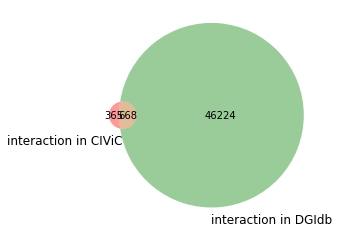

In [56]:
venn2([all_set1, all_set2], ('interaction in CIViC', 'interaction in DGIdb'))
plt.rcParams['figure.figsize'] = (30,5)
plt.show()

In [57]:
# explore the 365
civic_merge_nona.drop_duplicates(subset=['inter'], inplace=True)
civic_not_dgidb = civic_merge_nona[civic_merge_nona['inter'].isin(all_set1-all_set2)]
civic_not_dgidb

,0,molecular_profile,disease,last_review_date,inter
0,daunorubicin,DNMT3A,Acute Myeloid Leukemia,2023-01-09 21:46:25 UTC,DNMT3A-daunorubicin
6,peginterferon alfa-2b,JAK2,Polycythemia Vera,2023-01-09 21:46:26 UTC,JAK2-peginterferon alfa-2b
8,tanespimycin,NRAS,Melanoma,2023-01-09 21:46:27 UTC,NRAS-tanespimycin
9,temozolomide,NRAS,Melanoma,2023-01-09 21:46:27 UTC,NRAS-temozolomide
16,chemotherapy,NRAS,Colorectal Cancer,2023-01-09 21:46:27 UTC,NRAS-chemotherapy
...,...,...,...,...,...
1606,olaparib,SF3B1,Leukemia,2023-01-09 21:46:35 UTC,SF3B1-olaparib
1610,carboplatin,RRM1,Lung Non-small Cell Carcinoma,2023-01-09 21:46:44 UTC,RRM1-carboplatin
1612,platinum compound,ERCC1,Ovary Epithelial Cancer,2023-01-09 21:46:58 UTC,ERCC1-platinum compound
1616,r-chop regimen,MS4A1,Diffuse Large B-cell Lymphoma,2023-01-09 21:47:13 UTC,MS4A1-r-chop regimen


In [58]:
# explore the 365
civic_not_dgidb['last_review_date_only'] = pd.to_datetime(civic_not_dgidb['last_review_date']).dt.date
civic_not_dgidb

<ipython-input-58-f8888f9d0352>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  civic_not_dgidb['last_review_date_only'] = pd.to_datetime(civic_not_dgidb['last_review_date']).dt.date


,0,molecular_profile,disease,last_review_date,inter,last_review_date_only
0,daunorubicin,DNMT3A,Acute Myeloid Leukemia,2023-01-09 21:46:25 UTC,DNMT3A-daunorubicin,2023-01-09
6,peginterferon alfa-2b,JAK2,Polycythemia Vera,2023-01-09 21:46:26 UTC,JAK2-peginterferon alfa-2b,2023-01-09
8,tanespimycin,NRAS,Melanoma,2023-01-09 21:46:27 UTC,NRAS-tanespimycin,2023-01-09
9,temozolomide,NRAS,Melanoma,2023-01-09 21:46:27 UTC,NRAS-temozolomide,2023-01-09
16,chemotherapy,NRAS,Colorectal Cancer,2023-01-09 21:46:27 UTC,NRAS-chemotherapy,2023-01-09
...,...,...,...,...,...,...
1606,olaparib,SF3B1,Leukemia,2023-01-09 21:46:35 UTC,SF3B1-olaparib,2023-01-09
1610,carboplatin,RRM1,Lung Non-small Cell Carcinoma,2023-01-09 21:46:44 UTC,RRM1-carboplatin,2023-01-09
1612,platinum compound,ERCC1,Ovary Epithelial Cancer,2023-01-09 21:46:58 UTC,ERCC1-platinum compound,2023-01-09
1616,r-chop regimen,MS4A1,Diffuse Large B-cell Lymphoma,2023-01-09 21:47:13 UTC,MS4A1-r-chop regimen,2023-01-09


In [59]:
# explore the 365
civic_not_dgidb.groupby('last_review_date_only').count()[0]

last_review_date_only
2023-01-09    362
2023-01-12      1
2023-02-03      1
2023-02-21      1
Name: 0, dtype: int64

In [60]:
# explore the 46224
dgidb_i_nona.drop_duplicates(subset=['inter'], inplace=True)
dgidb_not_civic = dgidb_i_nona[dgidb_i_nona['inter'].isin(all_set2-all_set1)]
dgidb_not_civic

,gene_name,drug_name,interaction_claim_source,inter
0,CDK7,bms-387032,CancerCommons,CDK7-bms-387032
1,VDR,nifekalant,DTC,VDR-nifekalant
2,GPR55,bisacodyl,DTC,GPR55-bisacodyl
3,NR1H4,pentachlorophenol,DTC,NR1H4-pentachlorophenol
5,APOE,prednisone,NCI,APOE-prednisone
...,...,...,...,...
85449,CSF1R,chembl541400,DTC,CSF1R-chembl541400
85452,CDK8,chembl546797,DTC,CDK8-chembl546797
85455,PIK3C3,infigratinib,MyCancerGenome,PIK3C3-infigratinib
85458,PRKCA,resveratrol,DTC,PRKCA-resveratrol


In [61]:
# reminder: previous we drop the duplicates 
# by default it will keep the one random relationships among the duplicates
dgidb_not_civic.groupby('interaction_claim_source').count()['inter']

interaction_claim_source
CIViC                                150
COSMIC                                 1
CancerCommons                         21
ChemblInteractions                  5648
ClearityFoundationBiomarkers          39
ClearityFoundationClinicalTrial       49
DTC                                23185
DoCM                                   7
FDA                                  172
GuideToPharmacology                 3800
JAX-CKB                              882
MyCancerGenome                       339
MyCancerGenomeClinicalTrial           76
NCI                                 3213
OncoKB                                20
PharmGKB                            3537
TALC                                 155
TEND                                 810
TTD                                 2278
TdgClinicalTrial                    1842
Name: inter, dtype: int64

### Civic and Oncokb

In [62]:
onco_i_nona = onco_drug_gene_nona
onco_i_nona['inter'] = onco_i_nona['Gene'] +'-'+onco_i_nona[0]
onco_i_nona

,Gene,0,inter
0,ABL1,dasatinib,ABL1-dasatinib
1,ABL1,imatinib,ABL1-imatinib
2,ABL1,ponatinib,ABL1-ponatinib
3,ABL1,asciminib,ABL1-asciminib
4,ABL1,bosutinib,ABL1-bosutinib
...,...,...,...
434,ZRSR2,h3b-8800,ZRSR2-h3b-8800
467,MET,erlotinib,MET-erlotinib
468,MET,gefitinib,MET-gefitinib
469,MET,osimertinib,MET-osimertinib


In [63]:
# same unique numbers as previous summary section
onco_i_nona['inter'].nunique() # 230

230

In [64]:
all_set_onco = set(onco_i_nona['inter'])

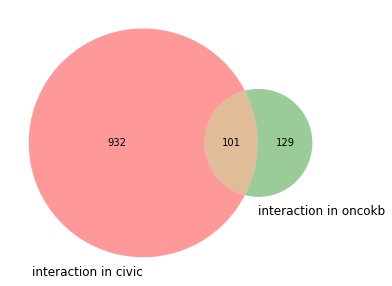

In [65]:
# different in ppt, since the venn diagram in ppt expanding the '+' relationship as well
venn2([all_set1, all_set_onco], ('interaction in civic', 'interaction in oncokb'))

### Digidb and Oncokb

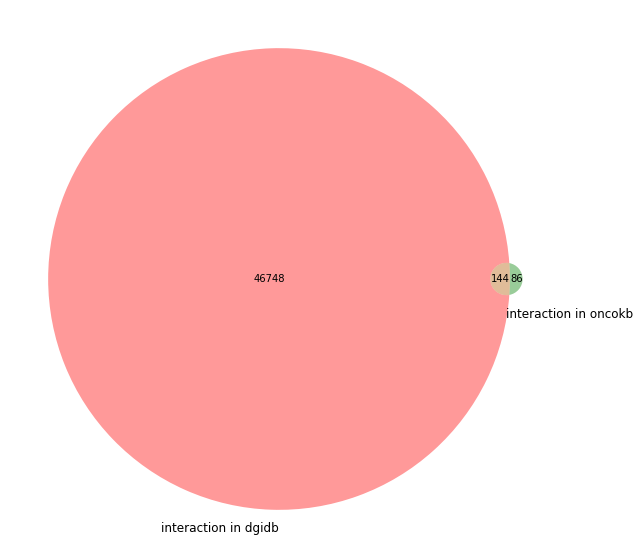

In [67]:
# different in ppt, since the venn diagram in ppt expanding the '+' relationship as well
venn2([all_set2, all_set_onco], ('interaction in dgidb', 'interaction in oncokb'))
plt.rcParams['figure.figsize'] = (60,10)
plt.show()

In [68]:
intersect = all_set2.intersection(all_set_onco)
print(len(intersect)) #144
dgidb_i_nona[dgidb_i_nona['inter'].isin(intersect)].groupby('interaction_claim_source').count()['inter']

144


interaction_claim_source
CIViC                              28
COSMIC                              2
CancerCommons                       2
ChemblInteractions                  3
ClearityFoundationBiomarkers        5
ClearityFoundationClinicalTrial     3
DTC                                 4
DoCM                                5
FDA                                 6
GuideToPharmacology                15
JAX-CKB                            17
MyCancerGenome                      6
MyCancerGenomeClinicalTrial         1
OncoKB                             22
PharmGKB                            8
TALC                                3
TEND                                2
TTD                                10
TdgClinicalTrial                    2
Name: inter, dtype: int64

In [69]:
dgidb_i_nona.groupby('interaction_claim_source').count()['inter']

interaction_claim_source
CIViC                                457
COSMIC                                 4
CancerCommons                         24
ChemblInteractions                  5662
ClearityFoundationBiomarkers          53
ClearityFoundationClinicalTrial       56
DTC                                23201
DoCM                                  17
FDA                                  183
GuideToPharmacology                 3826
JAX-CKB                             1008
MyCancerGenome                       354
MyCancerGenomeClinicalTrial           82
NCI                                 3230
OncoKB                                31
PharmGKB                            3585
TALC                                 160
TEND                                 817
TTD                                 2292
TdgClinicalTrial                    1850
Name: inter, dtype: int64